# 概率匹配集合平均方法（Probability-matched ensemble mean, PMM）

#### —— 对集合数值模式降水预报进行集成

国家气象中心天气预报技术研发室  
代刊, 唐健, June, 2021  

#### Questions
* 集合预报能较单个模式提供更多的预报信息, 但挑战在于如何从中获得最优预报?
* “点对点”的集合平均获得最优预报的常用方法, 但该方法对所有变量适用吗, 有没有更恰当的方法?

#### Objectives
* 了解简单集合平均存在的问题；
* 了解概率匹配集合平均方法(PMM)提出的背景；
* 掌握PMM算法的主要原理；
* 掌握PMM算法的主要优点和缺点；
* 了解PMM算法的改进方案；
* 编写PMM算法代码并进行应用。

---

In [1]:
# set up things
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# load necessary libraries
# you should install cartopy with 'conda install -c conda-forge cartopy'
import pickle
from pathlib import Path
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# load nmc_met_io for retrieving micaps server data
from nmc_met_io.retrieve_micaps_server import get_model_grid, get_model_grids
from nmc_met_graphics.plot.china_map import add_china_map_2cartopy
from nmc_met_base.ensemble import prob_matched_ens_mean, prob_matched_ens_mean_local

xr.set_options(display_style="text")

## “点对点”的集合平均
---

“点对点”集合平均即是所有集合成员预报值的算术平均值。通常情况下，集合平均相对于单个成员会表现处更低的预报误差。背后的主要原因是集合平均平滑掉了可预报性较低的信息而保留了可预报性较高的信息，因此集合平均的检验评分通常优于控制预报或单个成员预报。  

<img src="./images/Fig5.0.2 Spread Mean CTRL.png" alt="image" style="height: 350px;">

但对于包含复杂小尺度结构特征，或集合成员之间的变率较大和特征位置差异显著（如强对流系统，降水等），这时集合平均会导致：  
* 预报场过于平滑
* 预报系统空间覆盖出现偏大情况
* 预报系统强度出现偏小情况
* 系统的极值出现频率更低

In [3]:
# read ECMWF ensemble forecast data from MICAPS server
filename = "21053020.036"
datafile = (Path('samples/ensemble_forecast/') / Path(filename))
if datafile.is_file():
    # load data file
    with open(datafile, 'rb') as f:
        data = pickle.load(f)
else:
    directory = "ECMWF_ENSEMBLE/RAW/RAIN24/"
    data = get_model_grid(directory, filename=filename, varname='precipitation',
                          varattrs={'long_name':'accumulated precipitation', 'units':'mm'},
                          cache=False)
    # save data to file
    with open(datafile, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
data

<xarray.Dataset>
Dimensions:                  (lat: 121, lon: 261, number: 51, time: 1)
Coordinates:
  * number                   (number) int64 0 1 2 3 4 5 6 ... 45 46 47 48 49 50
  * time                     (time) datetime64[ns] 2021-06-01T08:00:00
  * lat                      (lat) float64 0.0 0.5 1.0 1.5 ... 59.0 59.5 60.0
  * lon                      (lon) float64 50.0 50.5 51.0 ... 179.0 179.5 180.0
    forecast_reference_time  datetime64[ns] 2021-05-30T20:00:00
    forecast_period          (time) float64 36.0
Data variables:
    precipitation            (number, time, lat, lon) float64 0.6866 ... 0.06104
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra Server

In [5]:
#
# extract data information

# extract subregion
map_extent=(112., 123., 20., 31.)
sub_data = data.sel(lon=slice(map_extent[0], map_extent[1]),
                    lat=slice(map_extent[2], map_extent[3]))

# coordinates and values
lon = sub_data.lon.values
lat = sub_data.lat.values
x, y = np.meshgrid(lon, lat)
mem = sub_data.number.values
values = np.squeeze(sub_data.precipitation.values)

# time information
rtime = sub_data.forecast_reference_time.values
fhour = int(sub_data.forecast_period.values[0])
vtime = rtime + np.timedelta64(fhour, 'h')

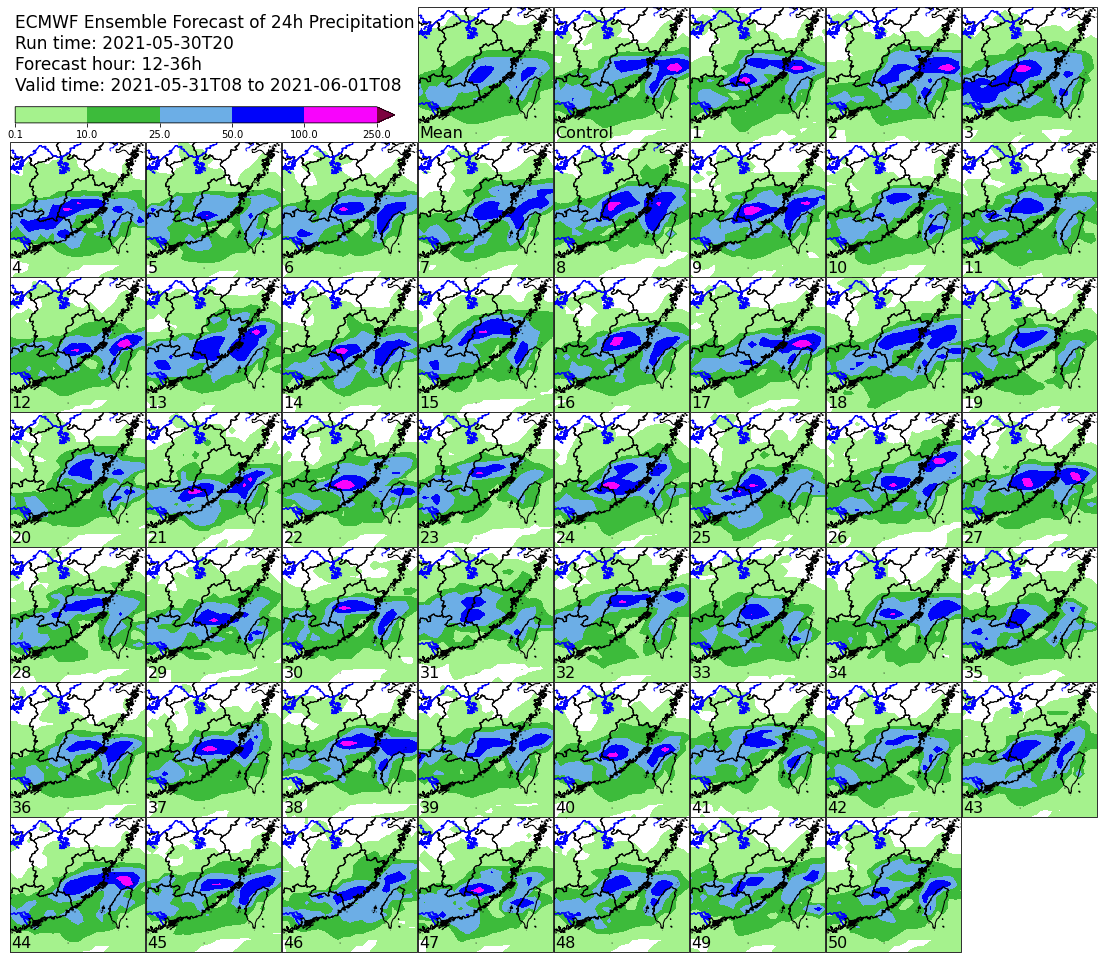

In [6]:
# set the number of subplots
nrow = 7
ncol = 8

# set figure and subplot size
width = 2.0
fig = plt.figure(figsize=(ncol*width+1.0, nrow*width+1.0))
gs = gridspec.GridSpec(
    nrow, ncol, wspace=0.0, hspace=0.0,
    top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
    left=0.5/(ncol+1), right=1-0.5/(ncol+1))

# set colors and levels
clevs = [0.1, 10, 25, 50, 100, 250]
colors = ['#a5f28d', '#3dbb3b', '#6caee6', '#0003fa', '#f804fc', '#7d0240']
cmap, norm = mpl.colors.from_levels_and_colors(clevs, colors, extend='max')

# set map parameters
datacrs = ccrs.PlateCarree()

# draw ensemble mean
ens_mean = values.mean(axis=0)    # calculate ensemble mean
ax = plt.subplot(gs[3], projection=datacrs)
ax.set_extent(map_extent, crs=datacrs)
plot1 = ax.contourf(x, y, ens_mean, clevs, norm=norm, cmap=cmap, transform=datacrs, extend="max")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.annotate("Mean", [0.01,0.03], xycoords='axes fraction', fontsize=16)

# draw ensemble control
ens_control = np.squeeze(values[0,:,:])
ax = plt.subplot(gs[4], projection=ccrs.PlateCarree())
ax.set_extent(map_extent, crs=datacrs)
plot2 = ax.contourf(x, y, ens_control, clevs, norm=norm, cmap=cmap, transform=datacrs, extend="max")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.annotate("Control", [0.01,0.03], xycoords='axes fraction', fontsize=16)

# draw ensemble perturbations
for i, imem in enumerate(mem[1:]):
    plot_numb = 5+i
    if plot_numb < gs.ncols*gs.nrows:
        ens_perturb = np.squeeze(values[imem,:,:])
        ax = plt.subplot(gs[plot_numb], projection=ccrs.PlateCarree())
        ax.set_extent(map_extent, crs=datacrs)
        plot3 = ax.contourf(x, y, ens_perturb, clevs, norm=norm, cmap=cmap, transform=datacrs, extend="max")
        add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
        add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
        ax.annotate(str(imem), [0.01,0.03], xycoords='axes fraction', fontsize=16)

# draw color bar
cb_ax = fig.add_axes([0.06, 0.83, 0.31, 0.015])
cbar = fig.colorbar(plot1, cax=cb_ax, orientation='horizontal')

# draw title
title = (
    "ECMWF Ensemble Forecast of 24h Precipitation \n"
    "Run time: {}\nForecast hour: {}h\n"
    "Valid time: {}").format(
        np.datetime_as_string(rtime, unit="h"),
        str(fhour-24)+'-'+str(fhour),
        np.datetime_as_string(vtime-np.timedelta64(24,'h'), unit="h")+' to '+
        np.datetime_as_string(vtime, unit="h"))
_ = plt.figtext(0.06, 0.86, title, fontsize=17)

<div class="alert alert-success">
    <b>EXERCISE</b>:
    对比当日集合模式降水预报的集合平均及控制成员预报:
     <ul>
      <li>利用nmc_met_io中的函数从Micaps服务器上读取当日集合预报24h累积降水量数据.</li>
      <li>计算全国区域的降水集合平均值.</li>
      <li>绘制集合平均降水量以及集合控制成员的降水量.</li>
      <li>进行对比分析，指出集合平均值的不足之处.</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

## 概率匹配集合平均方法
---

由*Ebert（2001）*提出并用于“穷人”集合预报。在其工作中，提出了权重平均（权重依据前期检验确定）、中位值预报、偏差校正（依据面积偏差比值线性变换集合平均场）和概率匹配平均来代替集合平均，检验结果表明多模式集成的结果的位移误差减少了30%；4种集成方法中，概率匹配平均方法结果最优。

<img src="./images/Ebert_2001_table_4.png" alt="image" style="height: 450px;">

### 权重平均（Weighted averaging） $AVG_{w}$  
当参与集成的模式成员之间表现出不同差异时，可以考虑权重平均。这个概念起源于Van den Dool and Rukhovets(1994)，其研究显示对500-hPa高度场预报量，根据模式前期的预报与实况对比，构建线性回归方程，相当于给定最优权重并进行平均，可以有效提高延伸期的预报能力。Krishnamurti et al.(1999, 2000)用同样的方法来预报经向风，不过是在每个格点上都建立相应的线性模型。Ebert（2001）实验此方案，结果中有可能包含降水负值。因此采用另外一种方案，即期望误差方差的反比(Xie and Arkin 1996; Huffman et al. 1997)，即计算前两个月中，整个预报区域期望误差方差的平均值，并以此值的反比来计算权重。Ebert计算模式的权重在0.07到0.22之间，检验结果表明权重平均$AVG_{w}$与集合平均$AVG$的预报能力相当。

### 中位数预报 (Median forecast)  $MED$ 及 $MAJ$
与位势高度场、温度等不同，降水频率分布呈现二项分布特征，即观测到的降水或者为零值，或者呈对数分布特征。因此，每个格点的降水量呈现非正态分布，特别是部分成员预报有降水，而另外部分成员预报没有降水的时候。因此，在此分布情况下，集合平均值并不能代表集合成员预报特征，为此提出集合中位值更恰当一些。计算得到的集合中位值$MED$降水面积有效减少，更接近实况，但降水总量偏低。    

在计算集合中位值$MED$的时候，当存在预报值为零的成员时，会降低最终预报值。为此，考虑只有半数的成员出现降水时，才计算有降水成员的中位值，得到最终结果$MAJ$。$MAJ$的平均降水强度接近观测，但降水总量仍偏大。

### 偏差降低 (Bias reduction) $AVG_{t}$
集合平均降低了降水极值，而扩大了降水范围。为此，设计偏差降低技术，基本思路是，设定最低降水阈值$r_{t}$，消除小于$r_{t}$的格点，然后调整剩余格点的降水量值，即通过降低小量值降水，增加大量级降水，实现区域降水总量的守恒。  
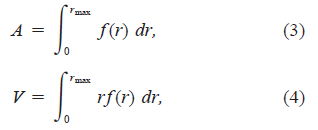  
上面公式中，$A$为降水面积，$V$为降水总量。区域面积采用如下公式订正：  
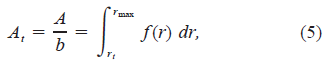    
这里$A_{t}$为订正后的降水面积，$b$为偏差系数，通过计算前期偏差得到。为了保证区域降水总量的守恒，需要将面积订正后的降水量值采用线性变换方式:  
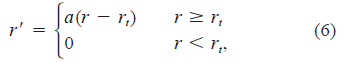    
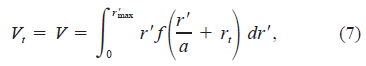  
对$AVG_{t}$检验表明，该方法非常好地订正了降水的面积偏差，但有$AVG$预报了过多的降水总量，导致$AVG_{t}$的降水平均强度偏大。

### 概率匹配 (Probability matching) $PM$
概率匹配技术用于融合不同时空分布的数据源：通常一种数据源具有较好的空间分布，而另一种数据具有更好的准确度。该技术早期用于融合雷达和降水站点观测（Rosenfeld et al. 1993), 或者静止和极轨卫星的降水估计融合（Anagnostou et al. 1999）。  

概率匹配技术的重要意义在于将数据源的空间分布特征和量级分布特征分别考虑，再进行融合处理。在集合预报中，我们假设集合平均场具有较好的空间分布特征，而集合成员预报具有更好的量级分布特征。如下图，给出概率匹配集合平均方法背后的逻辑：

>The QPFs rarely predict the rain pattern in exactly the same place. When combining multiple rain fields to produce a deterministic rain
forecast, the ensemble mean is likely to predict the best location of the rain center, but the averaging process "smears" the rain rates so that the
maximum rainfall is reduced and area of light rain is artificially enhanced (see plot below). However, the rain rate frequency distribution in the
original ensemble (collating all the rain rates from all the individual members) is usually closer to the observed rain rate frequency distribution.
Probability matching transforms the rain rate distribution in the ensemble mean rain field to look like that from the complete ensemble.

<img src="./images/Probability-matched ensemble mean.jpg" alt="image" style="height: 450px;">

<div class="alert alert-success">
    <b>EXERCISE</b>:
    对比全国2400多站点的24h累积降水的观测、集合平均、集合成员预报的频率分布曲线:
     <ul>
      <li>利用nmc_met_io中的函数从Micaps服务器上读取当日集合预报24h累积降水量数据.</li>
      <li>利用nmc_met_io中的函数从Micaps服务器上读取相应的站点观测预报数据.</li>
      <li>计算集合平均值，并将集合成员预报、集合平均预报插值到观测站点上.</li>
      <li>在同一张图上绘制降水的频率分布曲线，并进行对比.</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [7]:
# import retrieve function
from nmc_met_io.retrieve_cmadaas import cmadaas_obs_by_time

# 
datafile = Path('samples/ensemble_forecast/20210531000000.rain24.pkl')
if datafile.is_file():
    # load data file
    with open(datafile, 'rb') as f:
        data_obs = pickle.load(f)
else:
    # set retrieve parameters
    times = "20210531000000"
    data_code = "SURF_CHN_MUL_DAY"    # 逐小时观测资料
    elements = 'Station_Id_d,Datetime,Lat,Lon,Alti,PRE_Time_2020,PRE_Time_0808'

    # retrieve data
    data_obs = cmadaas_obs_by_time(times, data_code=data_code, elements=elements)
    data_obs = data_obs.dropna()
    
    # save data to file
    with open(datafile, 'wb') as f:
        pickle.dump(data_obs, f, protocol=pickle.HIGHEST_PROTOCOL)

# show data
data_obs

,Station_Id_d,Datetime,Lat,Lon,Alti,PRE_Time_2020,PRE_Time_0808
0,878119,2021-05-31,35.7372,108.1314,1370.1,0.0,0.0
1,878120,2021-05-31,36.0133,108.1183,1174.6,0.9,0.0
2,878116,2021-05-31,35.6750,108.3042,1430.6,0.3,0.0
3,878118,2021-05-31,35.9303,108.0317,1071.0,0.7,0.4
4,878123,2021-05-31,35.3278,107.9836,1183.0,0.0,0.0
...,...,...,...,...,...,...,...
65233,766993,2021-05-31,41.7572,121.4569,110.0,0.3,0.4
65234,767004,2021-05-31,41.0914,123.5778,167.0,0.0,5.5
65235,767005,2021-05-31,41.3631,122.8364,12.0,0.4,0.3
65236,767002,2021-05-31,40.8017,123.1464,254.0,0.0,0.0


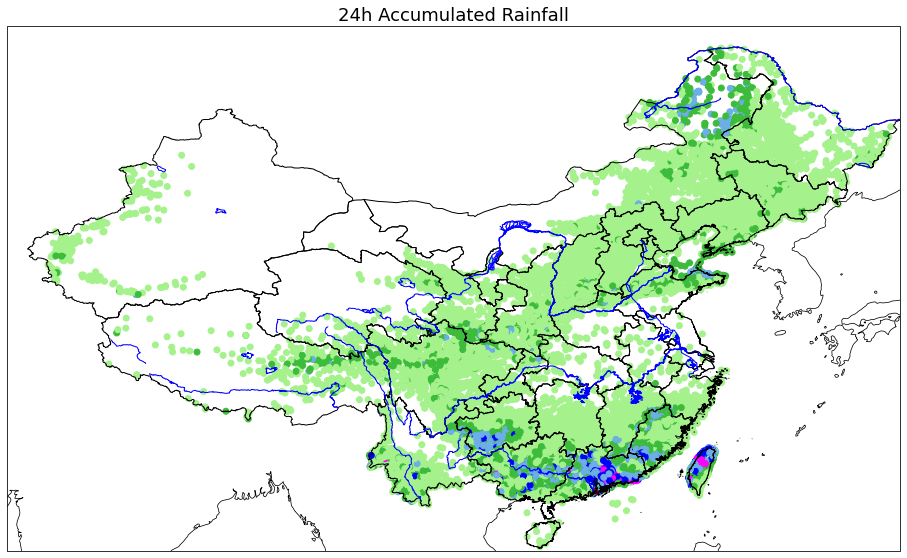

In [8]:
#
# draw ensemble mean

# set colors and levels
clevs = [0.1, 10, 25, 50, 100, 250]
colors = ['#a5f28d', '#3dbb3b', '#6caee6', '#0003fa', '#f804fc', '#7d0240']
cmap, norm = mpl.colors.from_levels_and_colors(clevs, colors, extend='max')

# set figure and subplot size
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 14))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([72, 135, 18, 55], crs=datacrs)

# draw ensemble mean
plt.scatter(x=data_obs['Lon'], y=data_obs['Lat'], c=data_obs['PRE_Time_0808'], 
            norm=norm, cmap=cmap, transform=datacrs)
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
plt.title("24h Accumulated Rainfall", fontsize=18)
plt.show()

In [9]:
#
# retrieve ensemble model forecast and interpolate to stations
filename = "21053020.036"
datafile = (Path('samples/ensemble_forecast/') / Path(filename))
with open(datafile, 'rb') as f:
    data_fcst = pickle.load(f)
    
# interpolate to stations
data_fcst_station = data_fcst.interp(lon=('points', data_obs['Lon']), lat=('points', data_obs['Lat']))
values_fcst_station = np.squeeze(data_fcst_station['precipitation'].values)

# compute ensemble mean
data_fcst_mean_station = data_fcst_station.mean('number')
values_fcst_mean_station = np.squeeze(data_fcst_mean_station['precipitation'].values)

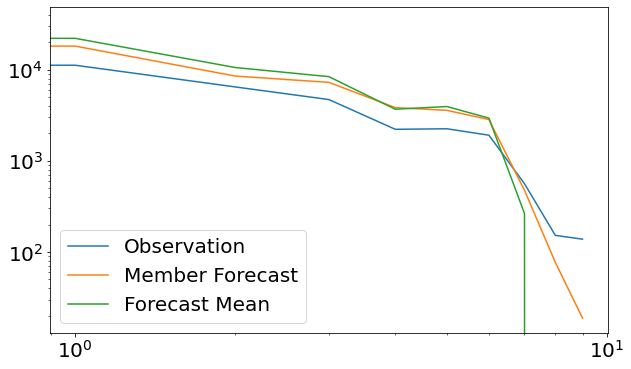

In [10]:
# compare the frequency of obs and forecast
bins = [0,0.1, 2, 5, 10, 15, 25, 50, 75, 100, 250]
obs_hist, _ = np.histogram(data_obs['PRE_Time_0808'], bins=bins)
fct_hist, _ = np.histogram(values_fcst_station, bins=bins) 
fct_hist = fct_hist / data_fcst_station['number'].size
fct_mean_hist, _ = np.histogram(values_fcst_mean_station, bins=bins)

plt.figure(figsize=(10,6))
plt.rcParams.update({"font.size":20})
plt.plot(np.arange(len(bins)-1), obs_hist, label="Observation")
plt.plot(np.arange(len(bins)-1), fct_hist, label="Member Forecast")
plt.plot(np.arange(len(bins)-1), fct_mean_hist, label="Forecast Mean")
plt.semilogx()
plt.semilogy()
plt.legend()
plt.show()

### 概率匹配集合平均方法(PMM)计算步骤

* 选定某一矩形格点区域（区域纬向$w$个格点，经向$h$个格点），计算该区域的集合平均场，并将$w×h$个格点集合平均值从大到小排列得到序列$A$；
* 每个格点上有$m$个成员，将区域内的$w×h×m$个集合成员预报值从大到小排列得到序列$C$；
* 将序列$C$顺序划分为 $w×h$个长度为$m$的序列段，从每个序列段抽取中值出来从大到小排列形成序列$B$；
* 用序列$B$的值替换$A$相同位置的平均值；将序列$A$恢复到集合平均场的原位置，即得到概率匹配平均场。

<img src="./images/Schematic_of_probability_matching_mean_method.png" alt="image" style="height: 400px;">

<div class="alert alert-success">
    <b>EXERCISE</b>:
    撰写概率匹配集合平均的算法函数:
     <ul>
      <li>利用nmc_met_io中的函数从Micaps服务器上读取当日集合预报24h累积降水量数据.</li>
      <li>按照上述计算步骤, 撰写概率匹配集合平均的算法函数.</li>
      <li>绘制图像, 对比集合平均、集合概率匹配平均场的差异.</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [11]:
# read ECMWF ensemble forecast data from MICAPS server
filename = "21053120.036"
datafile = (Path('samples/ensemble_forecast/') / Path(filename))
if datafile.is_file():
    # load data file
    with open(datafile, 'rb') as f:
        data = pickle.load(f)
else:
    directory = "ECMWF_ENSEMBLE/RAW/RAIN24/"
    data = get_model_grid(directory, filename=filename, varname='precipitation',
                          varattrs={'long_name':'accumulated precipitation', 'units':'mm'},
                          cache=False)
    # save data to file
    with open(datafile, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
data

<xarray.Dataset>
Dimensions:                  (lat: 121, lon: 261, number: 51, time: 1)
Coordinates:
  * number                   (number) int64 0 1 2 3 4 5 6 ... 45 46 47 48 49 50
  * time                     (time) datetime64[ns] 2021-06-02T08:00:00
  * lat                      (lat) float64 0.0 0.5 1.0 1.5 ... 59.0 59.5 60.0
  * lon                      (lon) float64 50.0 50.5 51.0 ... 179.0 179.5 180.0
    forecast_reference_time  datetime64[ns] 2021-05-31T20:00:00
    forecast_period          (time) float64 36.0
Data variables:
    precipitation            (number, time, lat, lon) float64 0.7324 ... 0.3319
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra Server

In [13]:
#
# extract data information

# coordinates and values
lon = data.lon.values
lat = data.lat.values
x, y = np.meshgrid(lon, lat)
mem = data.number.values
values = np.squeeze(data.precipitation.values)

# time information
rtime = data.forecast_reference_time.values
fhour = int(data.forecast_period.values[0])
vtime = rtime + np.timedelta64(fhour, 'h')

补充完整概率匹配集合平均函数, 输入集合成员预报数值, 输出概率匹配集合平均值

```Python
def prob_matched_ens_mean(values):
    """
    Perform probability-matched ensemble mean (PM).

    refer to:
    Ebert, E. E. (2001). "Ability of a poor man's ensemble to predict the probability 
      and distribution of precipitation." monthly weather review 129(10): 2461-2480.

    Args:
        values (np.array): ensemble forecasts, shape=(ensemble_members, lat, lon)

    Returns:
        np.array: probability-matched ensemble mean array, shape=(lat, lon)
    """
    
    # TO DO, complete the code ...
    
    # return
    return ens_pm_mean
```

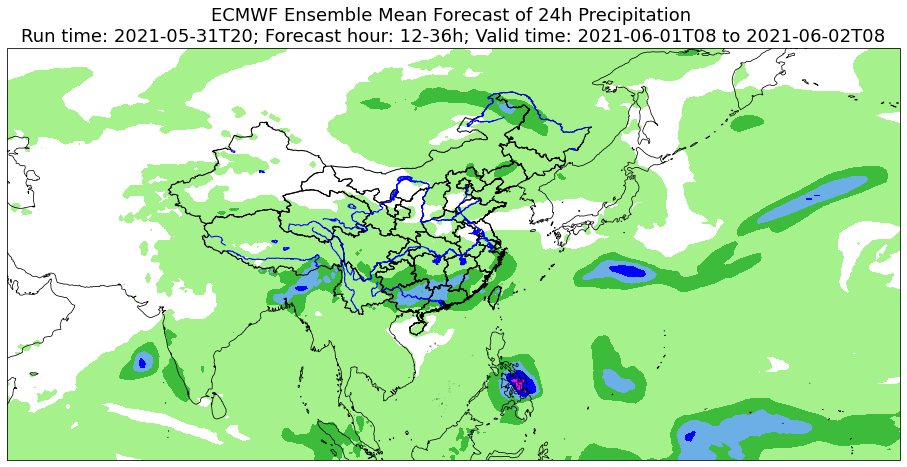

In [14]:
#
# draw ensemble mean

# set colors and levels
clevs = [0.1, 10, 25, 50, 100, 250]
colors = ['#a5f28d', '#3dbb3b', '#6caee6', '#0003fa', '#f804fc', '#7d0240']
cmap, norm = mpl.colors.from_levels_and_colors(clevs, colors, extend='max')

# set figure and subplot size
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(111, projection=datacrs)

# draw ensemble mean
ens_mean = values.mean(axis=0)    # calculate ensemble mean
plot = ax.contourf(x, y, ens_mean, clevs, norm=norm, cmap=cmap, transform=datacrs, extend="max")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
title = (
    "ECMWF Ensemble Mean Forecast of 24h Precipitation \n"
    "Run time: {}; Forecast hour: {}h; Valid time: {}").format(
        np.datetime_as_string(rtime, unit="h"),
        str(fhour-24)+'-'+str(fhour),
        np.datetime_as_string(vtime-np.timedelta64(24,'h'), unit="h")+' to '+
        np.datetime_as_string(vtime, unit="h"))
plt.title(title, fontsize=18)
plt.show()

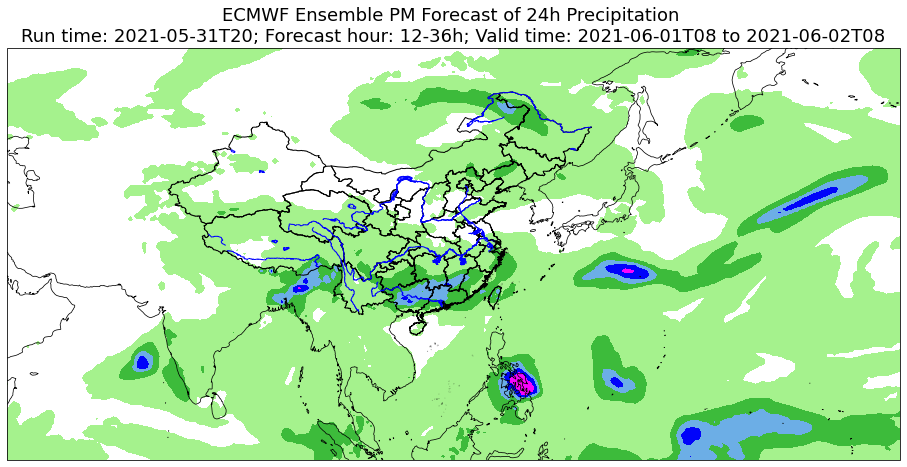

In [15]:
# set colors and levels
clevs = [0.1, 10, 25, 50, 100, 250]
colors = ['#a5f28d', '#3dbb3b', '#6caee6', '#0003fa', '#f804fc', '#7d0240']
cmap, norm = mpl.colors.from_levels_and_colors(clevs, colors, extend='max')

# set figure and subplot size
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(111, projection=datacrs)

# draw probability-matched ensemble mean
ens_pm_mean = prob_matched_ens_mean(values)
plot = ax.contourf(x, y, ens_pm_mean, clevs, norm=norm, cmap=cmap, transform=datacrs, extend="max")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
title = (
    "ECMWF Ensemble PM Forecast of 24h Precipitation \n"
    "Run time: {}; Forecast hour: {}h; Valid time: {}").format(
        np.datetime_as_string(rtime, unit="h"),
        str(fhour-24)+'-'+str(fhour),
        np.datetime_as_string(vtime-np.timedelta64(24,'h'), unit="h")+' to '+
        np.datetime_as_string(vtime, unit="h"))
plt.title(title, fontsize=18)
plt.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
    计算某一个子区域的概率匹配平均:
     <ul>
      <li>利用nmc_met_io中的函数从Micaps服务器上读取当日集合预报24h累积降水量数据.</li>
      <li>选取中国区域内降水比较集中的子区域, 计算概率匹配集合平均.</li>
      <li>绘制图像, 对比全域和子区域的集合概率匹配平均场的差异.</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

### 概率匹配集合平均带来的滤波效应
Surcel(2014)的研究结果表明，尽管PMM方法能够提供量级更真实，且预报技巧更高的预报结果，然而PMM的能量谱结构和空间分布完全不同于集合成员的预报量。

如下图, 给出集合模式降水预报场及其能量谱分布特征。图中, 图a)为控制预报，b)为集合平均，c)为采用Haar-wavelet low-pass filter(截断尺度128km)平滑方法的控制预报,d)为控制预报的能量谱乘上常数; e)为上述4中降水产品的不同尺度能量谱特征。

<img src="./images/Surcel_2014_fig3.png" alt="image" style="width: 600px;">  

* By definition, the integral below the power spectrum curve is a measure of the total variance of the field, while the slope of the power spectrum indicates how the total variance is distributed across scales.
* Reducing the total variance of the field of Fig. 3a by a constant factor such as in Fig. 3d, will result in changing the amplitude of the power spectrum, but not the slope; in this case, the power ratio would be different than 1 but constant with scale (black and green lines are parallel in Fig. 3e).
* When a smoother (i.e., a Haar-wavelet low-pass filter with a cutoff scale of 128 km) is applied to the field of Fig. 3a (Fig. 3c), the resulting power spectra will have the same amount of amplitude at the unaffected scales, but a different slope, as the variability at scales smaller than the smoother cutoff is gradually eliminated (black and blue lines in Fig. 3e).
* For scales larger than a cutoff scale $S_{0}$, the averaging acts as a smoother, giving more relative importance to larger scales, and gradually removing variability at smaller scales.
* For scales smaller than $S_{0}$, the averaging only affects the total variance at those scales, leaving the distribution of variance with scale unchanged.

<img src="./images/Surcel_2014_fig4.png" alt="image" style="width: 600px;">  

* For scales smaller than $S_{0}$, the ratio decreases with forecast lead time, but the ensemble members generally have more variability than the PMM at these scales. However, the probability matching does seem to affect the variance more at the smallest resolvable scales. 
* For scales larger than $S_{0}$, the ratio decreases with scale, becoming less than 1 for scales larger than about 300 km. 
* Therefore, the small-scale precipitation features, which are usually poorly predicted by any of the members, are less evident in the PMM fields—the PMM has less variance than the members at those scales. Conversely, features at scales larger than 300 km, which are generally better predicted by all members, are emphasized in the PMM fields (i.e., the power ratios with respect to the PMM are smaller than 1).

### 概率匹配集合平均的改进  
---

#### 应用于台风降水预报
Fang(2013)等应用于台风降水集合预报。其发展了一个改进的概率匹配技术，将多成员（32个成员）、低空间分辨率（36km）集合预报与少成员（8个成员）、高分分辨率的集合预报进行集成，获得更优的预报结果。  
> faced with the following challenges: 1) a large-size, highresolution ensemble is a desirable but expensive option and 2) a large-size, low-resolution ensemble is affordable and could produce a reasonable track forecast, but it most likely will systematically underpredict the precipitation amount.

The main features of the modified probability-matching technique include 
* 1) a resampling of a subset of the nearest LREN storm realizations (ignoring timing) for each ensemble mean LREN storm position at each verification time (at 3-h intervals in this paper), 
* 2) a resampling of a subset of the nearest HREN storm realizations (ignoring timing) for each selected LREN storm realization, 
* 3) an adjustment to the rainfall pattern in the SM of the selected HREN rainfall realizations using the rainfall distribution of the corresponding LREN rainfall realization, 
* 4) an improvement in the representativeness of the rainfall frequency distribution of the selected HREN rainfall realizations by a correction to the overprediction bias in the model, 
* 5) the use of probability matching based on the improved rainfall pattern and frequency distribution to reconstruct a synthetic 3-h rainfall ensemble at each verification time.

<img src="./images/Fang_2013_Fig4.png" alt="image" style="width: 800px;">  

### 局地概率匹配集合平均 (LPMM)

Clark(2017)的研究指出，当在较大区域内计算概率匹配集合平均时，会导致降水量值空间分布的失真，即遥远区域的降水分布会影响本地降水，直接导致的结果是会进一步扩大降水区域范围，并收缩或消除小区域降水。为此，他提出局地概率匹配技术：

* 1) calculate the traditional ensemble mean at each grid point (i.e., same as step 1 for the PM mean);
* 2) within a 126-km radius of each grid point, sort the values of ensemble mean from lowest to highest and record the rank $R_{mean}$ of the center point; 
* 3) within a 126-km radius of each grid point, sort the values of all ensemble members from lowest to highest; 
* 4) replace the value of the neighborhood center point with the sorted ensemble member value ranked $R_{ens}$.

<img src="./images/Clark_2017_Fig3.png" alt="image" style="width: 800px;">  

<div class="alert alert-success">
    <b>EXERCISE</b>:
    实现局地概率匹配平均算法:
     <ul>
      <li>利用nmc_met_io中的函数从Micaps服务器上读取当日集合预报24h累积降水量数据.</li>
      <li>编写局地概率匹配集合平均的计算程序, 主要考虑矩形区域, 区域尺寸可以调节.</li>
      <li>绘制图像, 对比全域概率匹配集合平均场，不同邻域半径的局地概率匹配集合平均场的差异.</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [16]:
# read ECMWF ensemble forecast data from MICAPS server
filename = "21053120.036"
datafile = (Path('samples/ensemble_forecast/') / Path(filename))
if datafile.is_file():
    # load data file
    with open(datafile, 'rb') as f:
        data = pickle.load(f)
else:
    directory = "ECMWF_ENSEMBLE/RAW/RAIN24/"
    data = get_model_grid(directory, filename=filename, varname='precipitation',
                          varattrs={'long_name':'accumulated precipitation', 'units':'mm'},
                          cache=False)
    # save data to file
    with open(datafile, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
#
# extract data information

# coordinates and values
lon = data.lon.values
lat = data.lat.values
x, y = np.meshgrid(lon, lat)
mem = data.number.values
values = np.squeeze(data.precipitation.values)

# time information
rtime = data.forecast_reference_time.values
fhour = int(data.forecast_period.values[0])
vtime = rtime + np.timedelta64(fhour, 'h')

补充完整局地概率匹配集合平均函数, 输入集合成员预报数值, 输出概率匹配集合平均值

```Python
def prob_matched_ens_mean_local(values, half_width=10):
    """Calculate local probability-matched ensemble mean field.

    Args:
        values (np.array): ensemble forecasts, shape=(ensemble_members, lat, lon)
        half_width (scaler, optional): the half width of local square.
    
    Returns:
        np.array: local probability-matched ensemble mean array, shape=(lat, lon)
    """

    # get dimensions
    _, nlat, nlon = values.shape

    # construct result variables
    ens_pm_mean = np.zeros((nlat, nlon))
    
    # TO DO, complete the code ...
    
    # return
    return ens_pm_mean
```

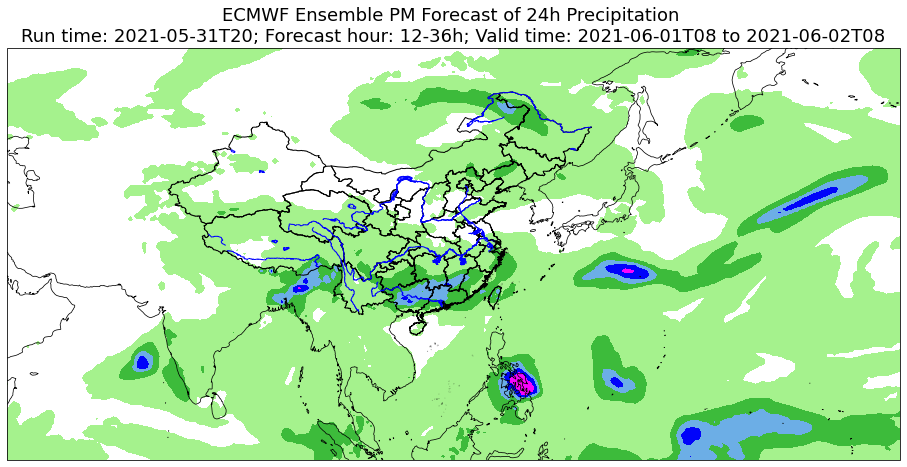

In [17]:
# set colors and levels
clevs = [0.1, 10, 25, 50, 100, 250]
colors = ['#a5f28d', '#3dbb3b', '#6caee6', '#0003fa', '#f804fc', '#7d0240']
cmap, norm = mpl.colors.from_levels_and_colors(clevs, colors, extend='max')

# set figure and subplot size
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(111, projection=datacrs)

# draw probability-matched ensemble mean
ens_pm_mean = prob_matched_ens_mean(values)
plot = ax.contourf(x, y, ens_pm_mean, clevs, norm=norm, cmap=cmap, transform=datacrs, extend="max")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
title = (
    "ECMWF Ensemble PM Forecast of 24h Precipitation \n"
    "Run time: {}; Forecast hour: {}h; Valid time: {}").format(
        np.datetime_as_string(rtime, unit="h"),
        str(fhour-24)+'-'+str(fhour),
        np.datetime_as_string(vtime-np.timedelta64(24,'h'), unit="h")+' to '+
        np.datetime_as_string(vtime, unit="h"))
plt.title(title, fontsize=18)
plt.show()

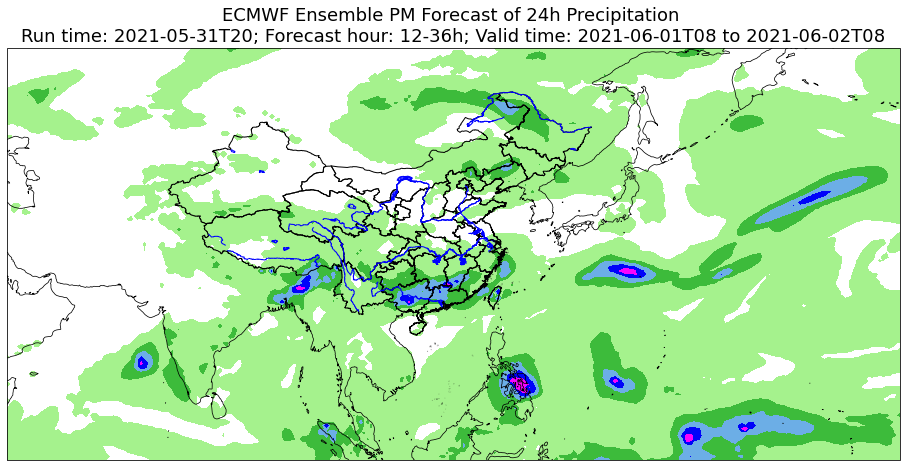

CPU times: user 30.4 s, sys: 891 µs, total: 30.4 s
Wall time: 30.4 s


In [18]:
%%time

# set colors and levels
clevs = [0.1, 10, 25, 50, 100, 250]
colors = ['#a5f28d', '#3dbb3b', '#6caee6', '#0003fa', '#f804fc', '#7d0240']
cmap, norm = mpl.colors.from_levels_and_colors(clevs, colors, extend='max')

# set figure and subplot size
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(111, projection=datacrs)

# draw probability-matched ensemble mean
ens_pm_mean = prob_matched_ens_mean_local(values, half_width=10)
plot = ax.contourf(x, y, ens_pm_mean, clevs, norm=norm, cmap=cmap, transform=datacrs, extend="max")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
title = (
    "ECMWF Ensemble PM Forecast of 24h Precipitation \n"
    "Run time: {}; Forecast hour: {}h; Valid time: {}").format(
        np.datetime_as_string(rtime, unit="h"),
        str(fhour-24)+'-'+str(fhour),
        np.datetime_as_string(vtime-np.timedelta64(24,'h'), unit="h")+' to '+
        np.datetime_as_string(vtime, unit="h"))
plt.title(title, fontsize=18)
plt.show()

### 基于逐点和逐块计算的局地概率匹配集合平均

Snook(2020)为解决逐点局地概率匹配集合平均计算的问题，提出逐块计算局地概率匹配集合平均方案，使其计算速度更快，且性能相当.

<img src="./images/snook_2020_Fig1.png" alt="image" style="width: 800px;">  

<img src="./images/snook_2020_Fig2.png" alt="image" style="width: 800px;">  

## References

* Ebert, E. E. (2001). "Ability of a poor man's ensemble to predict the probability and distribution of precipitation." monthly weather review 129(10): 2461-2480.
* Surcel, M., et al. (2014). "On the Filtering Properties of Ensemble Averaging for Storm-Scale Precipitation Forecasts." monthly weather review 142(3): 1093-1105.
* Fang, X. Q. and Y. H. Kuo (2013). "Improving Ensemble-Based Quantitative Precipitation Forecasts for Topography-Enhanced Typhoon Heavy Rainfall over Taiwan with a Modified Probability-Matching Technique." monthly weather review 141(11): 3908-3932.
* Snook, N., et al. (2020). "Comparison and Verification of Point-Wise and Patch-Wise Localized Probability-Matched Mean Algorithms for Ensemble Consensus Precipitation Forecasts." Geophysical Research Letters 47(12).